In [1]:
# Dependencies
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import hvplot.pandas

# Import the API key
from api_keys import geoapify_key

In [2]:
# set path
data_path = "project4/Resources/studentInfo.csv"

# read the csv file into pandas and remove unnamed columns
data_df = pd.read_csv(data_path, index_col=0, encoding="UTF-8")
data2_df = data_df.dropna(how="any", axis=0)

data2_df.head()

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
code_module,,,,,,,,,,,
AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [3]:
 # Import SQLAlchemy `automap` and other dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

In [4]:
# Create the connection engine
engine = create_engine("sqlite:///open_university_small.sqlite")

In [5]:
 # Create the inspector and connect it to the engine
inspector = inspect(engine)

In [6]:
 # Collect the names of tables within the database
inspector.get_table_names()

['assessments',
 'courses',
 'studentAssessment',
 'studentInfo',
 'studentRegistration',
 'vle']

In [7]:
 # Using the inspector to print the column names within the 'StudentInfo' table and its types
columns = inspector.get_columns('studentInfo')
for column in columns:
    print(column["name"], column["type"])

index BIGINT
code_module TEXT
code_presentation TEXT
id_student BIGINT
gender TEXT
region TEXT
highest_education TEXT
imd_band TEXT
age_band TEXT
num_of_prev_attempts BIGINT
studied_credits BIGINT
disability TEXT
final_result TEXT


In [8]:
query = '''
select * from studentInfo
'''
sql2_df = pd.read_sql_query(query, engine)
sql2_df

,index,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


In [9]:
len(sql2_df.index)

32593

In [10]:
sql3_df = sql2_df.value_counts(['region']).reset_index(name='Region Total')

sql3_df

,region,Region Total
0,Scotland,3446
1,East Anglian Region,3340
2,London Region,3216
3,South Region,3092
4,North Western Region,2906
5,West Midlands Region,2582
6,South West Region,2436
7,East Midlands Region,2365
8,South East Region,2111
9,Wales,2086


In [11]:
#Add Latitude and Longitude
sql3_df["Lat"] = ""
sql3_df["Lon"] = ""
sql3_df

,region,Region Total,Lat,Lon
0,Scotland,3446,,
1,East Anglian Region,3340,,
2,London Region,3216,,
3,South Region,3092,,
4,North Western Region,2906,,
5,West Midlands Region,2582,,
6,South West Region,2436,,
7,East Midlands Region,2365,,
8,South East Region,2111,,
9,Wales,2086,,


In [12]:
#Change name so Geo_apify can find
sql3_df = sql3_df.replace('Scotland', 'Glasgow, Scotland')
sql3_df = sql3_df.replace('East Anglian Region', 'Norwich, England')
sql3_df = sql3_df.replace('London Region', 'London, England')
sql3_df = sql3_df.replace('South Region', 'Southampton, England')
sql3_df = sql3_df.replace('North Western Region', 'Manchester, England')
sql3_df = sql3_df.replace('West Midlands Region', 'Birmingham, England')
sql3_df = sql3_df.replace('South West Region', 'Bristol, England')
sql3_df = sql3_df.replace('East Midlands Region', 'Birmingham, England')
sql3_df = sql3_df.replace('South East Region', 'Brighton, England')
sql3_df = sql3_df.replace('Wales', 'Cardiff, Wales')
sql3_df = sql3_df.replace('Yorkshire Region', 'Leeds, England')
sql3_df = sql3_df.replace('North Region', 'Newcastle, England')
sql3_df = sql3_df.replace('Ireland', 'Dublin, Ireland')
sql3_df

,region,Region Total,Lat,Lon
0,"Glasgow, Scotland",3446,,
1,"Norwich, England",3340,,
2,"London, England",3216,,
3,"Southampton, England",3092,,
4,"Manchester, England",2906,,
5,"Birmingham, England",2582,,
6,"Bristol, England",2436,,
7,"Birmingham, England",2365,,
8,"Brighton, England",2111,,
9,"Cardiff, Wales",2086,,


In [13]:
 # Define the API parameters
params = {
    "apiKey":geoapify_key,
    "format":"json"
}

# Set the base URL
base_url = "https://api.geoapify.com/v1/geocode/search"

In [14]:
# Loop through the cities_pd DataFrame and search coordinates for each city
for index, row in sql3_df.iterrows():

    # Get the city's name & add ", Australia" to the string so geoapify finds the correct city
    city = row["region"] 

    # Add the current city to the parameters
    params["text"] = f"{city}"

    # Make the API request
    response = requests.get(base_url, params=params)
    
    # Convert reponse to JSON
    response = response.json()

    # Extract latitude and longitude
    sql3_df.loc[index, "Lat"] = response["results"][0]["lat"]
    sql3_df.loc[index, "Lon"] = response["results"][0]["lon"]

# Display sample data to confirm that the coordinates appear
sql3_df

,region,Region Total,Lat,Lon
0,"Glasgow, Scotland",3446,55.861155,-4.250169
1,"Norwich, England",3340,52.628558,1.292395
2,"London, England",3216,51.507446,-0.127765
3,"Southampton, England",3092,50.902535,-1.404189
4,"Manchester, England",2906,53.479489,-2.245115
5,"Birmingham, England",2582,52.479699,-1.902691
6,"Bristol, England",2436,51.453802,-2.597298
7,"Birmingham, England",2365,52.479699,-1.902691
8,"Brighton, England",2111,50.821463,-0.140056
9,"Cardiff, Wales",2086,51.481655,-3.179193


In [15]:
%%capture --no-display
# Configure the map plot
map_plot = sql3_df.hvplot.points(
    "Lon",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 840,
    frame_height = 600,
    size = "Region Total",
    scale = 0.75,
    color = "region"
)

# Display the map plot
map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lon,Lat]   (region,Region Total)

In [16]:
sql4_df = sql2_df.value_counts(['gender']).reset_index(name='Gender Total')
sql4_df = sql4_df.set_index('gender')

sql4_df

,Gender Total
gender,
M,17875
F,14718


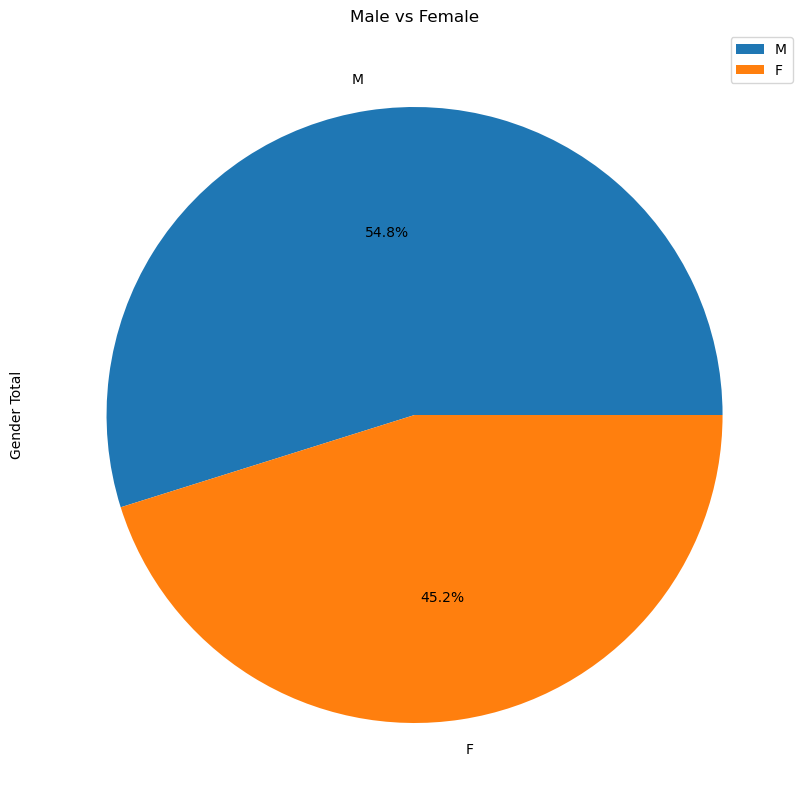

In [17]:
#Plot Pie chart
plot = sql4_df.plot.pie(y='Gender Total', title = "Male vs Female", autopct='%1.1f%%', figsize=(10, 10))

In [38]:
sql5_df = sql2_df.value_counts(['final_result']).reset_index(name='Pass Total')

sql5_df

,final_result,Pass Total
0,Pass,12361
1,Withdrawn,10156
2,Fail,7052
3,Distinction,3024


In [39]:
pass_df = sql5_df.replace('Withdrawn', 'Fail')
pass_df = pass_df.replace('Distinction', 'Pass')

pass_df

,final_result,Pass Total
0,Pass,12361
1,Fail,10156
2,Fail,7052
3,Pass,3024


In [44]:
pass2_df = pass_df.groupby('final_result').sum()

pass3_df = pass2_df.reset_index()

pass3_df

,final_result,Pass Total
0,Fail,17208
1,Pass,15385


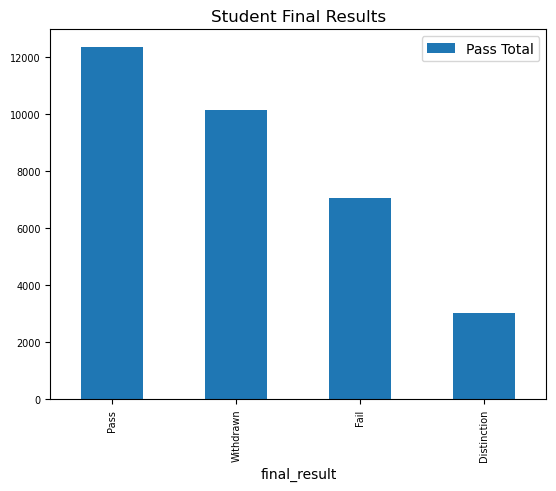

In [41]:
bargraph = sql5_df.plot.bar(x = 'final_result', y = 'Pass Total', title = "Student Final Results", fontsize='7')

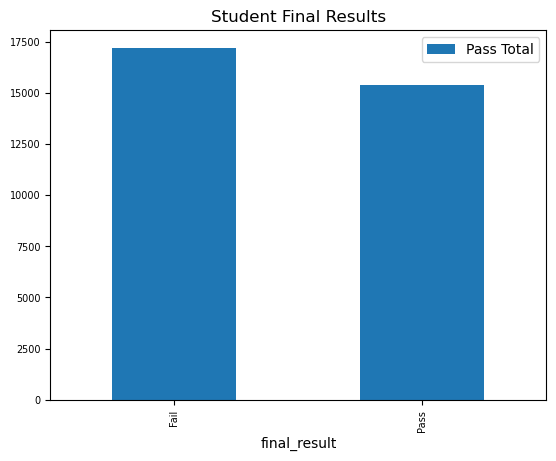

In [45]:
bargraph = pass3_df.plot.bar(x = 'final_result', y = 'Pass Total', title = "Student Final Results", fontsize='7')

In [20]:
sql6_df = sql2_df.value_counts(['code_module']).reset_index(name='Totals for Each Module')

sql6_df

,code_module,Totals for Each Module
0,BBB,7909
1,FFF,7762
2,DDD,6272
3,CCC,4434
4,EEE,2934
5,GGG,2534
6,AAA,748


In [21]:
data6_df = sql2_df.value_counts(['age_band']).reset_index(name='Totals for Each Age_Band')
data6_df = data6_df.set_index('age_band')


data6_df

,Totals for Each Age_Band
age_band,
0-35,22944
35-55,9433
55<=,216


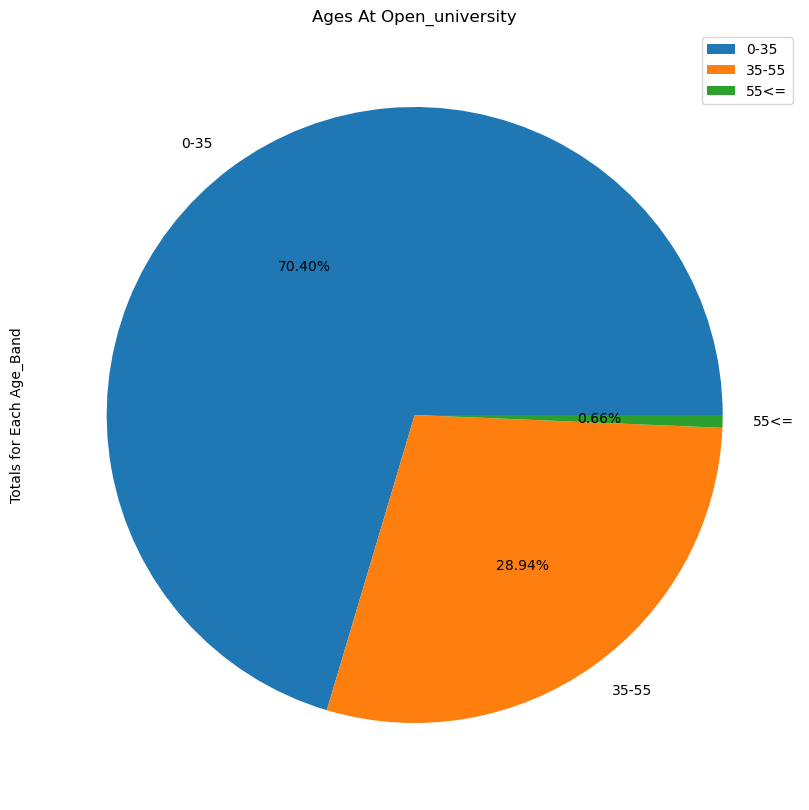

In [22]:
#Plot Pie chart
plot = data6_df.plot.pie(y='Totals for Each Age_Band', title = "Ages At Open_university", autopct='%1.2f%%', figsize=(10, 10))